In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

from astroExplain.spectra.explanation import TellMeWhy
from anomaly.constants import GALAXY_LINES
from anomaly.utils import line_width_from_velocity

In [2]:
# %%capture output
# set minor ticks on x axis as a default for all plots
# add minor ticks for all axes


def set_minorticks(axs):

    for ax in axs.flat:
        ax.minorticks_on()

In [3]:
# directories for data
bin_id = "bin_03"
user = "/home/edgar"
work_directory = f"{user}/spectra/0_01_z_0_5_4_0_snr_inf"
model = "256_128_64/latent_12/"
# metric = "mse_filter_250kms_noRel100"
metric = "mse_filter_250kms_noRel97"
# metric = "mse_noRel97"
# metric = "mse_filter_250kms_rel100"
# metric = "mse_filter_250kms_rel97"
# metric = "mse_rel100"
# metric = "mse_rel97"
data_directory = f"{work_directory}/{bin_id}/" f"explanation/{model}/{metric}"

In [4]:
wave = np.load(f"{work_directory}/wave_spectra_imputed.npy")

anomalies = np.load(f"{data_directory}/top_anomalies.npy")

df_anomalies = pd.read_csv(
    f"{data_directory}/top_anomalies.csv.gz", index_col="specobjid"
)

median_spectrum = np.load(f"{work_directory}/{bin_id}/median_spectrum.npy")
mean_spectrum = np.load(f"{work_directory}/{bin_id}/average_spectrum.npy")

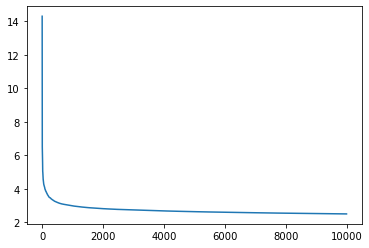

In [5]:
# sort scores in descending order in place in the df
df_anomalies.sort_values(by="score", ascending=False, inplace=True)
anomalies = anomalies[::-1]
plt.plot(df_anomalies["score"].to_numpy())

Explore average patterns

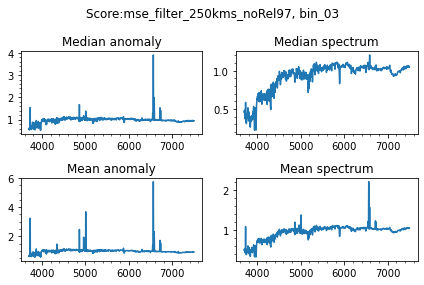

In [6]:
# average for top 10k anomalies
median_anomaly_10k = np.median(anomalies, axis=0)
mean_anomaly_10k = np.mean(anomalies, axis=0)

# compare against mean and median spectra
fig, axs = plt.subplots(2, 2, figsize=None, tight_layout=True)
# add minor ticks for all axes
set_minorticks(axs)

# add title to the figure
fig.suptitle(f"Score:{metric}, {bin_id}", fontsize=12)

axs[0, 0].plot(wave, median_anomaly_10k)
axs[0, 0].set_title("Median anomaly")

axs[1, 0].plot(wave, mean_anomaly_10k)
axs[1, 0].set_title("Mean anomaly")

axs[0, 1].plot(wave, median_spectrum)
axs[0, 1].set_title("Median spectrum")

axs[1, 1].plot(wave, mean_spectrum)
axs[1, 1].set_title("Mean spectrum")

# save median and mean spectra for later use
np.save(f"{data_directory}/median_anomaly_10k.npy", median_anomaly_10k)

np.save(f"{data_directory}/mean_anomaly_10k.npy", mean_anomaly_10k)

# save figure to pdf in Downloads folder
fig.savefig(f"{data_directory}/{metric}_{bin_id}_median_mean_anomaly_10k.pdf")

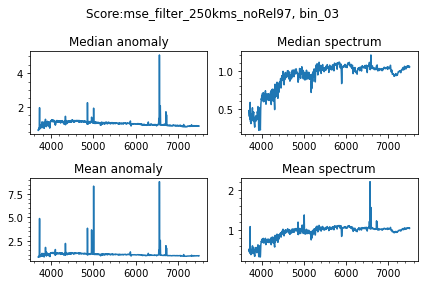

In [7]:
# average for top 1k anomalies
median_anomaly_1k = np.median(anomalies[:1000], axis=0)
mean_anomaly_1k = np.mean(anomalies[:1000], axis=0)

# compare against mean and median spectra
fig, axs = plt.subplots(2, 2, figsize=None, tight_layout=True)
# add minor ticks for all axes
set_minorticks(axs)

# add title to the figure
fig.suptitle(f"Score:{metric}, {bin_id}", fontsize=12)

axs[0, 0].plot(wave, median_anomaly_1k)
axs[0, 0].set_title("Median anomaly")

axs[1, 0].plot(wave, mean_anomaly_1k)
axs[1, 0].set_title("Mean anomaly")

axs[0, 1].plot(wave, median_spectrum)
axs[0, 1].set_title("Median spectrum")

axs[1, 1].plot(wave, mean_spectrum)
axs[1, 1].set_title("Mean spectrum")

# save median and mean spectra for later use
np.save(f"{data_directory}/median_anomaly_1k.npy", median_anomaly_1k)

np.save(f"{data_directory}/mean_anomaly_1k.npy", mean_anomaly_1k)

# save figure to pdf in Downloads folder
fig.savefig(f"{data_directory}/{metric}_{bin_id}_median_mean_anomaly_1k.pdf")

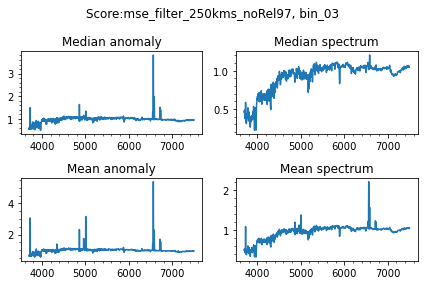

In [8]:
# average for top 1k to 10k anomalies
median_anomaly_1to10k = np.median(anomalies[1000:], axis=0)
mean_anomaly_1to10k = np.mean(anomalies[1000:], axis=0)

# compare against mean and median spectra
fig, axs = plt.subplots(2, 2, figsize=None, tight_layout=True)
# add minor ticks for all axes
set_minorticks(axs)

# add title to the figure
fig.suptitle(f"Score:{metric}, {bin_id}", fontsize=12)

axs[0, 0].plot(wave, median_anomaly_1to10k)
axs[0, 0].set_title("Median anomaly")

axs[1, 0].plot(wave, mean_anomaly_1to10k)
axs[1, 0].set_title("Mean anomaly")

axs[0, 1].plot(wave, median_spectrum)
axs[0, 1].set_title("Median spectrum")

axs[1, 1].plot(wave, mean_spectrum)
axs[1, 1].set_title("Mean spectrum")

# save median and mean spectra for later use
np.save(f"{data_directory}/median_anomaly_1to10k.npy", median_anomaly_1to10k)

np.save(f"{data_directory}/mean_anomaly_1to10k.npy", mean_anomaly_1to10k)

# save figure to pdf in Downloads folder
fig.savefig(
    f"{data_directory}/{metric}_{bin_id}_median_mean_anomaly_1to10k.pdf"
)

## Explore explanations

In [9]:
%%capture output
# config
median_smooth = True
drop_fraction = 0.05

# create array with weights for top all anomalies

explanations_directory = f"{data_directory}/000"

weights_all = np.empty(anomalies.shape)

for i, specobjid in enumerate(df_anomalies.index.to_numpy()):

    with open(f"{explanations_directory}/{specobjid}.pkl", "rb") as file:

        explanation = pickle.load(file)
        why = TellMeWhy(wave=wave, explanation=explanation)

        weights_all[i, :] = why.smooth_and_normalize_explanation(
            median_smooth=median_smooth, drop_fraction=drop_fraction
        )

# new array to store the absolute values of the weights
weights_all_abs = np.abs(weights_all)

# save both arrays for later use
np.save(
    f"{data_directory}/weights_all_"
    f"smooth_{median_smooth}_drop_{drop_fraction}"
    f"{metric}_{bin_id}.npy",
    weights_all,
)

np.save(
    f"{data_directory}/weights_all_abs"
    f"smooth_{median_smooth}_drop_{drop_fraction}"
    f"{metric}_{bin_id}.npy",
    weights_all_abs,
)

## Summary stats of explanation weights

In [15]:
# mean and median of the explanation weights for all anomalies
mean_weights_abs = np.mean(weights_all_abs, axis=0)
median_weights_abs = np.median(weights_all_abs, axis=0)


# # plot the mean and median of the weights
# fig, axs = plt.subplots(2, 1, figsize=None, tight_layout=True)

# # add title to the figure

# fig.suptitle(
#     f"Mean and median weights top 10k anomalies, {metric}, {bin_id}",
#     fontsize=12
# )

# # add minor ticks for all axes
# for ax in axs.flat:
#     ax.minorticks_on()

# axs[0].plot(wave, mean_weigh_all_abs)
# axs[0].set_title("Mean weights top 10k anomalies")

# axs[1].plot(wave, median_weigh_all_abs)
# axs[1].set_title("Median weights top 10k anomalies")

# # save figure to pdf in data directory

# fig.savefig(
#     f"{data_directory}/abs_mean_median_weights_top_10k_anomalies.pdf"
# )

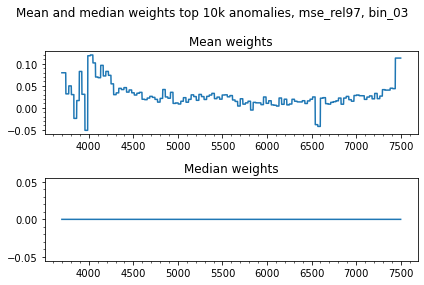

In [9]:
# repeat previous steps for but on the original weights_all array

mean_weigh_all = np.mean(weights_all, axis=0)
median_weigh_all = np.median(weights_all, axis=0)

fig, axs = plt.subplots(2, 1, figsize=None, tight_layout=True)

# add title to the figure

fig.suptitle(
    f"Mean and median weights top 10k anomalies, {metric}, {bin_id}",
    fontsize=12,
)

# add minor ticks for all axes
for ax in axs.flat:
    ax.minorticks_on()

axs[0].plot(wave, mean_weigh_all)
axs[0].set_title("Mean weights")

axs[1].plot(wave, median_weigh_all)
axs[1].set_title("Median weights")

# save figure to pdf in data directory

fig.savefig(f"{data_directory}/mean_median_weights_top_10k_anomalies.pdf")

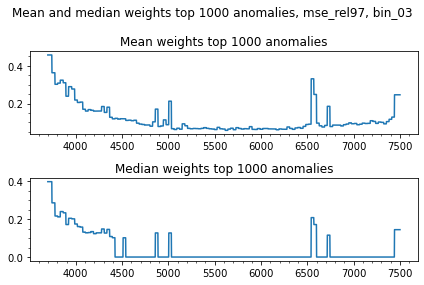

In [10]:
# mean and median of the explanation weights for the top 1000 anomalies

mean_weigh_top_1000 = np.mean(weights_all_abs[:1000], axis=0)
median_weigh_top_1000 = np.median(weights_all_abs[:1000], axis=0)

fig, axs = plt.subplots(2, 1, figsize=None, tight_layout=True)

# add title to the figure

fig.suptitle(
    f"Mean and median weights top 1000 anomalies, {metric}, {bin_id}",
    fontsize=12,
)

# add minor ticks for all axes
for ax in axs.flat:
    ax.minorticks_on()

axs[0].plot(wave, mean_weigh_top_1000)
axs[0].set_title("Mean weights top 1000 anomalies")

axs[1].plot(wave, median_weigh_top_1000)
axs[1].set_title("Median weights top 1000 anomalies")

# save figure to pdf in data directory

fig.savefig(f"{data_directory}/abs_mean_median_weights_top_1000_anomalies.pdf")

## Inspect std of explanation weights

Text(0.5, 1.0, 'STD weights absolute values')

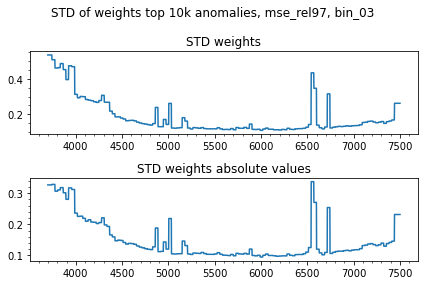

In [11]:
# compute sd of the weights along the wavelength axis

sd_weights_all = np.std(weights_all, axis=0)
sd_weights_all_abs = np.std(weights_all_abs, axis=0)

# plot the sd of the weights

fig, axs = plt.subplots(2, 1, figsize=None, tight_layout=True)

# add title to the figure

fig.suptitle(
    f"STD of weights top 10k anomalies, {metric}, {bin_id}", fontsize=12
)

# add minor ticks for all axes
for ax in axs.flat:
    ax.minorticks_on()

axs[0].plot(wave, sd_weights_all)
axs[0].set_title("STD weights")

axs[1].plot(wave, sd_weights_all_abs)
axs[1].set_title("STD weights absolute values")

Text(0.5, 1.0, 'STD weights absolute values')

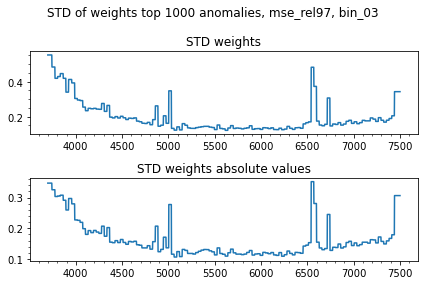

In [12]:
# compute standard deviation of the weights along the wavelength axis for the top 1000 anomalies

sd_weights_top_1000 = np.std(weights_all[:1000], axis=0)
sd_weights_top_1000_abs = np.std(weights_all_abs[:1000], axis=0)

# plot the sd of the weights

fig, axs = plt.subplots(2, 1, figsize=None, tight_layout=True)

# add title to the figure

fig.suptitle(
    f"STD of weights top 1000 anomalies, {metric}, {bin_id}", fontsize=12
)

# add minor ticks for all axes
for ax in axs.flat:
    ax.minorticks_on()

axs[0].plot(wave, sd_weights_top_1000)
axs[0].set_title("STD weights")

axs[1].plot(wave, sd_weights_top_1000_abs)
axs[1].set_title("STD weights absolute values")